In [1]:
import numpy as np
import pyqubo as pq
import sympy as sp
from PyQubo_formulation import *
from Utilities import *

import neal
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [6]:
root = np.array([0,4], dtype='float')

ulen = 6

# eps1 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)
# eps2 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)

# domains = np.tile(root, (ulen,1))

# domains[:,0] = domains[:,0]+eps1
# domains[:,1] = domains[:,1]+eps2


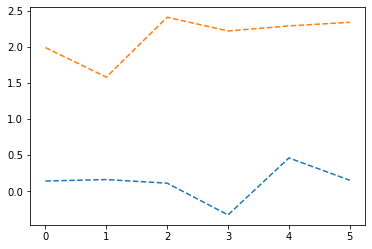

In [3]:
plt.plot(domains[:,0], '--')
plt.plot(domains[:,1], '--')
plt.show()

In [7]:
nq_u = 6
u = Create_float_vec(ulen, nq_u, root)
u[0]

(2.000000 * (((((Binary('q[0]') + (0.500000 * Binary('q[1]'))) + (0.250000 * Binary('q[2]'))) + (0.125000 * Binary('q[3]'))) + (0.062500 * Binary('q[4]'))) + (0.031250 * Binary('q[5]'))))

In [21]:
# l = u[0]**2
# l.compile().to_qubo()

usquared = [u[i]**2 for i in range(len(u))]
umods = [usquared[i].compile().to_qubo() for i in range(len(usquared))]
umods

[({('q[1]', 'q[3]'): 0.5382031250000001,
   ('q[2]', 'q[2]'): -1.6606484375,
   ('q[1]', 'q[1]'): -2.78309375,
   ('q[0]', 'q[0]'): -3.4133749999999994,
   ('q[0]', 'q[3]'): 1.0764062500000002,
   ('q[1]', 'q[2]'): 1.0764062500000002,
   ('q[0]', 'q[2]'): 2.1528125000000005,
   ('q[0]', 'q[1]'): 4.305625000000001,
   ('q[2]', 'q[3]'): 0.26910156250000006,
   ('q[3]', 'q[3]'): -0.897599609375},
  3.4595999999999996),
 ({('q[4]', 'q[5]'): 4.730624999999999,
   ('q[4]', 'q[6]'): 2.3653124999999995,
   ('q[4]', 'q[7]'): 1.1826562499999997,
   ('q[5]', 'q[6]'): 1.1826562499999997,
   ('q[6]', 'q[7]'): 0.29566406249999994,
   ('q[5]', 'q[7]'): 0.5913281249999999,
   ('q[6]', 'q[6]'): -2.2925859374999997,
   ('q[5]', 'q[5]'): -3.993843749999999,
   ('q[7]', 'q[7]'): -1.2202089843749997,
   ('q[4]', 'q[4]'): -5.622374999999999},
  5.6644),
 ({('q[10]', 'q[11]'): 0.23765624999999999,
   ('q[11]', 'q[9]'): 0.47531249999999997,
   ('q[8]', 'q[8]'): -2.4764999999999993,
   ('q[10]', 'q[8]'): 1.901

In [11]:
muparams = np.array([6,[0,4]], dtype='object')

maxnorm = Max_Norm_LP(u, 1, muparams, muparams)

model = maxnorm.compile(strength=5)

model_qubo = model.to_qubo(index_label=True)

np.trace(Dict_to_Mat(model_qubo[0]))

2179.2686462402344

In [30]:
sampler = neal.SimulatedAnnealingSampler()

gamma = np.linspace(1,5,10)

results = []
for i in range(len(gamma)):
    
    maxnorm = Max_Norm_LP(u, gamma[i], muparams, muparams)

    model = maxnorm.compile(strength=1)

    model_qubo = model.to_qubo(index_label=True)
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=100)

    samples = sampleset.samples()
    energies = sampleset.record['energy']
    
    min_energy = np.min(energies)

    errors = np.zeros(len(samples))
    for j in range(len(samples)):
        if np.abs(min_energy - energies[j]) <= np.abs(min_energy)/10:
            results.append(samples[j])


1000


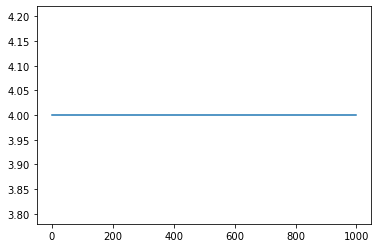

In [31]:
values = [float_approx(results[i],root) for i in range(len(results))]
print(len(values))
plt.plot(values)
plt.show()

In [30]:
import dimod

sampler_exact = dimod.ExactSolver()
sampler_exact.parameters

model_bqm = dimod.BQM.from_qubo(model_qubo[0])

In [31]:
sampleset = sampler_exact.sample(model_bqm)

samples = sampleset.samples()
energies = sampleset.record['energy']

errors = np.zeros(len(samples))
for j in range(len(samples)):
    errors[j] = quad_error(samples[j], quad_vars)


median = np.median(errors)
mean = np.mean(errors)


ValueError: Maximum allowed dimension exceeded

In [10]:
# Dimond doesn't work so look at SA again

import neal

sampler = neal.SimulatedAnnealingSampler()

sampler.parameters

{'beta_range': [],
 'num_reads': [],
 'num_sweeps': [],
 'beta_schedule_type': ['beta_schedule_options'],
 'seed': [],
 'interrupt_function': [],
 'initial_states': [],
 'initial_states_generator': []}

In [13]:
M = np.linspace(1, 20, 40)

median = np.zeros(len(M))
mean = np.zeros(len(M))

energies = np.zeros(len(M), dtype='object')
samples = np.zeros(len(M), dtype='object')

for i in range(len(M)):
    
    maxnorm = Max_Norm_LP(u, M[i], muparams, muparams)
    
    model = maxnorm.compile(strength=5)

    model_qubo = model.to_qubo()
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

    samples[i] = sampleset.samples()
    energies[i] = sampleset.record['energy']

#     errors = np.zeros(len(samples))
#     for j in range(len(samples)):
#         errors[j] = quad_error(samples[j], quad_vars)
    
#     plt.plot(errors, color=scalarMap.to_rgba(M[i]))
    
#     median[i] = np.median(errors)
#     mean[i] = np.mean(errors)

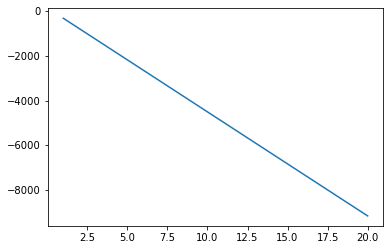

In [21]:
min_e = np.zeros(len(energies))

for i in range(len(energies)):
    min_e[i] = np.min(energies[i])
plt.plot(M, min_e)
plt.show()

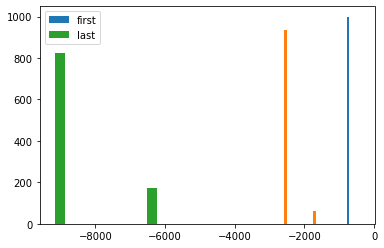

In [38]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=1, vmax=M[-1])
cm = plt.get_cmap('hot_r')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.hist(energies[1], label='first')
plt.hist(energies[10])
plt.hist(energies[39], label='last')
plt.legend()
plt.show()